# T3 - Juan Luis Baldelomar Cabrera

In [1]:
import nltk 
import numpy as np

# Load Data

In [2]:
def load_data(filename, labels_filename):
    file = open(filename, 'r')
    labels_file = open(labels_filename, 'r')
    tweets = file.read()
    labels = labels_file.read()
    documents = tweets.split('\n')
    labels = labels.split('\n')
    return documents, labels

In [3]:
from nltk import TweetTokenizer
from nltk.corpus import stopwords

def process_documents(documents):
    # tokenize each document
    documents_tokenized = []
    tokenizer = TweetTokenizer()
    for doc in documents:
        documents_tokenized.append(tokenizer.tokenize(doc.lower()))
    return documents_tokenized

def remove_stop_words(documents):
    # build dictionary of stopwords
    stopwords_dict = {word:1 for word in stopwords.words('spanish')}
    non_stop_documents = []
    for doc in documents:
        ndoc = []
        for word in doc:
            if stopwords_dict.get(word) == None:
                ndoc.append(word)
        non_stop_documents.append(ndoc)
    
    return non_stop_documents

In [4]:
documents, labels = load_data('data/mex_train.txt', 'data/mex_train_labels.txt')
val_documents, val_labels = load_data('data/mex_val.txt', 'data/mex_val_labels.txt')

#remove extra lines
documents.pop(-1)
val_documents.pop(-1)
labels.pop(-1)
val_labels.pop(-1)

''

In [5]:
documents = process_documents(documents)
val_documents = process_documents(val_documents)
all_docs = documents + val_documents
y_train = list(map(int, labels))
y_val = list(map(int, val_labels))
y_all = y_train + y_val

In [68]:
documents[0]

['lo',
 'peor',
 'de',
 'todo',
 'es',
 'que',
 'no',
 'me',
 'dan',
 'por',
 'un',
 'tiempo',
 'y',
 'luego',
 'vuelven',
 'estoy',
 'hasta',
 'la',
 'verga',
 'de',
 'estl']

In [69]:
def normalize_matrix(matrix):
    norm = np.linalg.norm(matrix, axis=1)
    # Add 1 if norm == 0 to avoid division by 0. --  Increase 1 dimension for broadcast 
    mat = matrix / (norm + (norm==0 + 0.0))[:, np.newaxis]
    return mat

# BoW Builder Class

In [140]:
from nltk import TweetTokenizer
from nltk.probability import FreqDist
import numpy as np

class BoWBuilder:
    # UTILITIES
    def get_dimensions(self):
        return self.voc_index.keys()
    
    # INIT FUNCTIONS
    def __init__(self):
        # attributes
        self.voc_index = {} 
        self.train_idf = None
        self.T = 0
        
    def get_vocabulary(self, documents, T):
        # get vocabulary
        tokens = [token for doc in documents for token in doc]
        vocabulary = FreqDist(tokens)
        
        self.T = min(T, len(vocabulary.keys()))
        
        # get most common words
        limited_voc = vocabulary.most_common(T)
        self.voc_index = {}
        
        # get index of words in matrix
        for i, word_count in enumerate(limited_voc):
            self.voc_index[word_count[0]] = i
    
    
    # BUILD BOW MATRIX
    def build_bow(self, documents, T=5000, voc_index=None, mode='train', weight_scheme='binary', normalize=False):
        # get most common terms - training mode
        if mode == 'train':
            if voc_index==None:
                self.get_vocabulary(documents, T) #use most common words as vocabulary
            else:
                # use vocabulary index sent as parameter. Usefull when performing a features reduction or working with n-grams
                self.voc_index = voc_index
                self.T = len(voc_index.keys())
        
        # use train_idf, testing mode
        use_train_idf = mode != 'train'
        
        # get weights for matrix
        if weight_scheme == 'tf':
            bow = self.frequency_bow(documents)
        elif weight_scheme == 'tf-idf':
            # if documents!= None, use existing idf weights (val or test mode)
            bow = self.frequency_bow(documents, use_idf=True, use_train_idf=use_train_idf)
        else:
            bow = self.binary_bow(documents)
        
        # normalize if necessary
        if normalize:
            bow = normalize_matrix(matrix)
                    
        return bow
            
    # WEIGHT SCHEMES
    def binary_bow(self, documents):
        N = len(documents)
        T = self.T
        
        bow = np.zeros((N, T))
        for i, doc in enumerate(documents):
            for word in doc:
                j = self.voc_index.get(word)
                if j != None:
                    bow[i, j] = 1 
        
        return bow
    
    def frequency_bow(self, documents, use_idf=False, use_train_idf=False):
        N = len(documents)
        T = self.T
        bow = np.zeros((N, T))
        
        # tf scheme
        for i, doc in enumerate(documents):
            for word in doc:
                j = self.voc_index.get(word)
                if j != None:
                    bow[i, j] += 1 
        
        # tf-idf scheme
        if use_idf:
            if not use_train_idf:
                # calculate idf for first time (training mode)
                self.train_idf = np.sum(bow>0, axis=0)
            
            bow = np.log(bow + 1) * np.log(N/self.train_idf)
            
        return bow        

# Feature Selection

## Chi Square

La siguiente implementación de la métrica Chi Cuadrado se encuentra basada en el libro Information Retrieval de Baeza. Sin embargo la función tiene un pequeño inconveniente y es que el denominador se puede volver 0 si para una cierta palabra $k_i$ tenemos que aparece en todos los términos, pues la ecuación es de la forma 

$$\chi^2(k_i, c_p) = \frac{N_t\Big(P(k_i,c_p)P(\bar{k}_i, \bar{c}_p)- P(k_i,\bar{c}_p)P(\bar{k}_i, c_p)\Big)^2}{P(k_i)P(\bar{k}_i)P(c_p)P(\bar{c}_p)} \quad (1)$$

Si tomamos una versión continua en función de $P(k_i)$ y $P(\bar{k}_i) = 1 - P(k_i)$ entonces podemos tomar el límite cuando $P(k_i) \rightarrow 1$. Podríamos suponer de manera razonable que si las clases están balanceadas o por lo menos no están sesgadas totalmente a una sola clase, debido a que $P(k_i)\rightarrow 1$, entonces $k_i$ aparece en casi todos los documentos y por lo tanto existe una independencia entre el evento de obtener el término $k_i$ y la clase $c_p$.  Con esta información podemos desarrollar aún más la ecuación de arriba de manera que $P(k_i, c_p) = P(k_i)P(c_p)$ (debido a que asumimos que era razonable suponer la independencia) y al aplicar el límite y tener una forma indeterminada podemos aplicar la regla de L'hospital y tras derivar tanto el numerador como el denominador tenemos que el límite es 0. 

Si analizamos esto de manera intuitiva tiene sentido. Sabemos que la $\chi^2$ cuadrado cuantifica la falta de independencia entre ambas variables. Esta métrica por definición es no negativa. Si el término $k_i$ aparece en todos los documentos (como una stop word) entonces básicamente lo podemos pensar como en que el término no revela información sobre la posible etiqueta del documento, lo cual también se sigue de que supusimos de que los eventos eran independientes.

Por lo tanto utilizaremos la métrica 

$$\chi^2(k_i, c_p) =  \begin{cases}{(1) \quad \quad \text{si} \quad P(k_i)\neq 1}\\
{0 \quad \quad \text{caso contrario}}
\end{cases}$$

Notemos que el caso $P(k_i)=0$ no es necesario considerarlo, porque en ese escenario el término no debería siquiera aparecer. Otro caso particular del denominador en que se vuelve 0 es cuando todos los documentos son de una sola etiqueta. Pero como se mencionó anteriormente, supondríamos que este no es el caso pues si se quiere entrenar un modelo se debe tener documentos de más de una sola clase. 

In [70]:
def chi_sqr(tf_matrix, labels):
    Nt = len(tf_matrix)
    n_i = np.sum(tf_matrix>0, axis=0)
    n_i1 = np.sum((tf_matrix * labels)>0, axis=0)
    n_i0 = np.sum((tf_matrix * (1-labels))>0, axis=0)
    n_1 = np.sum(labels, axis=0)
    n_0 = Nt - n_1
    # compute chi
    chi_1 = Nt*(Nt * n_i1 - n_1 * n_i)**2/(n_1 * n_i * (Nt - n_1) * (Nt - n_i))
    chi_0 = Nt*(Nt * n_i0 - n_0 * n_i)**2/(n_0 * n_i * (Nt - n_0) * (Nt - n_i))
    
    # get chi average
    chi_avg = n_1/Nt * chi_1 +  n_0/Nt * chi_0 
    
    return np.nan_to_num(chi_avg)

def reduce_dims(bow, voc_index, labels, n=-1, limit=-1):
    # compute chi avg
    chi_avg = chi_sqr(bow, np.array(labels)[:, np.newaxis])
    lim = np.mean(chi_avg) if limit==-1 else limit
    
    new_dict = {}
    counter = 0
    
    if n != -1:
        n_max_chi = np.flip(np.argsort(chi_avg))[:n]
        voc_index_list = list(voc_index)
        for i, index in enumerate(n_max_chi):
            word = voc_index_list[index]
            new_dict[word] = i
        chi_avg = chi_avg[n_max_chi]
    else:
        for i, word in enumerate(voc_index.keys()):
            if chi_avg[i] >= lim:
                new_dict[word] = counter
                counter += 1
        chi_avg = chi_avg[chi_avg>=lim]
        
    return new_dict, chi_avg

## Obtener Diccionario del vocabulario del conjunto de entrenamiento y toda la colección con Corte de Chi Cuadrado

Obtendremos el vocabulario a utilizar haciendo un corte con la métrica chi cuadrado para ambos conjuntos de datos.

In [71]:
def get_features(documents, labels, n, T=10000):
    bow_builder = BoWBuilder()
    bow = bow_builder.build_bow(documents, T=T, weight_scheme='tf')
    voc_index, chi = reduce_dims(bow, bow_builder.voc_index, labels, n=n)
    return voc_index, chi

In [179]:
voc_index, _ = get_features(documents, y_train, 5000)
all_docs_voc_index, _ = get_features(all_docs, y_all, 5000)

# TCOR Class and PPMI

In [12]:
def ppmi(mat, alpha):
    c = np.sum(mat)**alpha 
    col_m = np.sum(mat, axis=1)[:, np.newaxis]
    row_m = np.sum(mat**alpha, axis=0)[np.newaxis, :]
    pwc= mat/c                                  #P(w,c)
    pw = col_m/c                                #P(w)
    pc = row_m/c                                #P(c)
    
    return np.maximum(np.log2(pwc/(pw * pc)), 0)  

In [60]:
from nltk.probability import FreqDist
import numpy as np
class TCOR:
    def __init__(self):
        self.voc_index = {}
        self.T = 0
        
    def get_vocabulary(self, documents, T):
        # get vocabulary
        tokens = [token for doc in documents for token in doc]
        vocabulary = FreqDist(tokens)
        print(len(vocabulary.keys()))
        
        self.T = min(T, len(vocabulary.keys()))
        
        # get most common words
        limited_voc = vocabulary.most_common(self.T)
        
        # get index of words in matrix
        for i, word_count in enumerate(limited_voc):
            self.voc_index[word_count[0]] = i
    
    def build_matrix(self, documents, window_size, alpha=0.75, smooth_k=0.1, mode='train', T=5000, voc_index=None, use_ppmi=True, use_center=True):
        # get most common terms - training mode
        if mode == 'train':
            if voc_index==None:
                self.get_vocabulary(documents, T) #use most common words as vocabulary
            else:
                # use vocabulary index sent as parameter. Usefull when performing a features reduction or working with n-grams
                self.voc_index = voc_index
                self.T = len(voc_index.keys())
        
        term_matrix = self.frequency(documents, window_size, use_center)
        if use_ppmi:
            term_matrix = ppmi(term_matrix + smooth_k, alpha)
            
        return term_matrix
    
    def frequency(self, documents, window_size, use_center):
        term_matrix = np.zeros((self.T, self.T))
        
        # tf scheme
        for doc in documents:
            for c, center in enumerate(doc):
                start, end = max(0, c-window_size), min(len(doc), c + window_size + 1)
                context_words = doc[start:c] + doc[c+1:end] if not use_center else doc[start: end]
                context_index = [j for j in map(self.voc_index.get, context_words) if j != None]
                i  = self.voc_index.get(center)
                if i == None:
                    continue
                    
                for j in context_index:
                    term_matrix[i, j] += 1
        
        return term_matrix

# 1. Matriz TCOR y Visualizaciones

## 2000 términos y Ventana de tamaño 3

In [163]:
voc_index, _ = get_features(documents, y_train, 2000)
tcor = TCOR()
term_matrix = tcor.build_matrix(documents, 3, voc_index=voc_index)

In [164]:
import numpy as np
from sklearn.manifold import TSNE
reduced_matrix = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(term_matrix)

In [165]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[0]

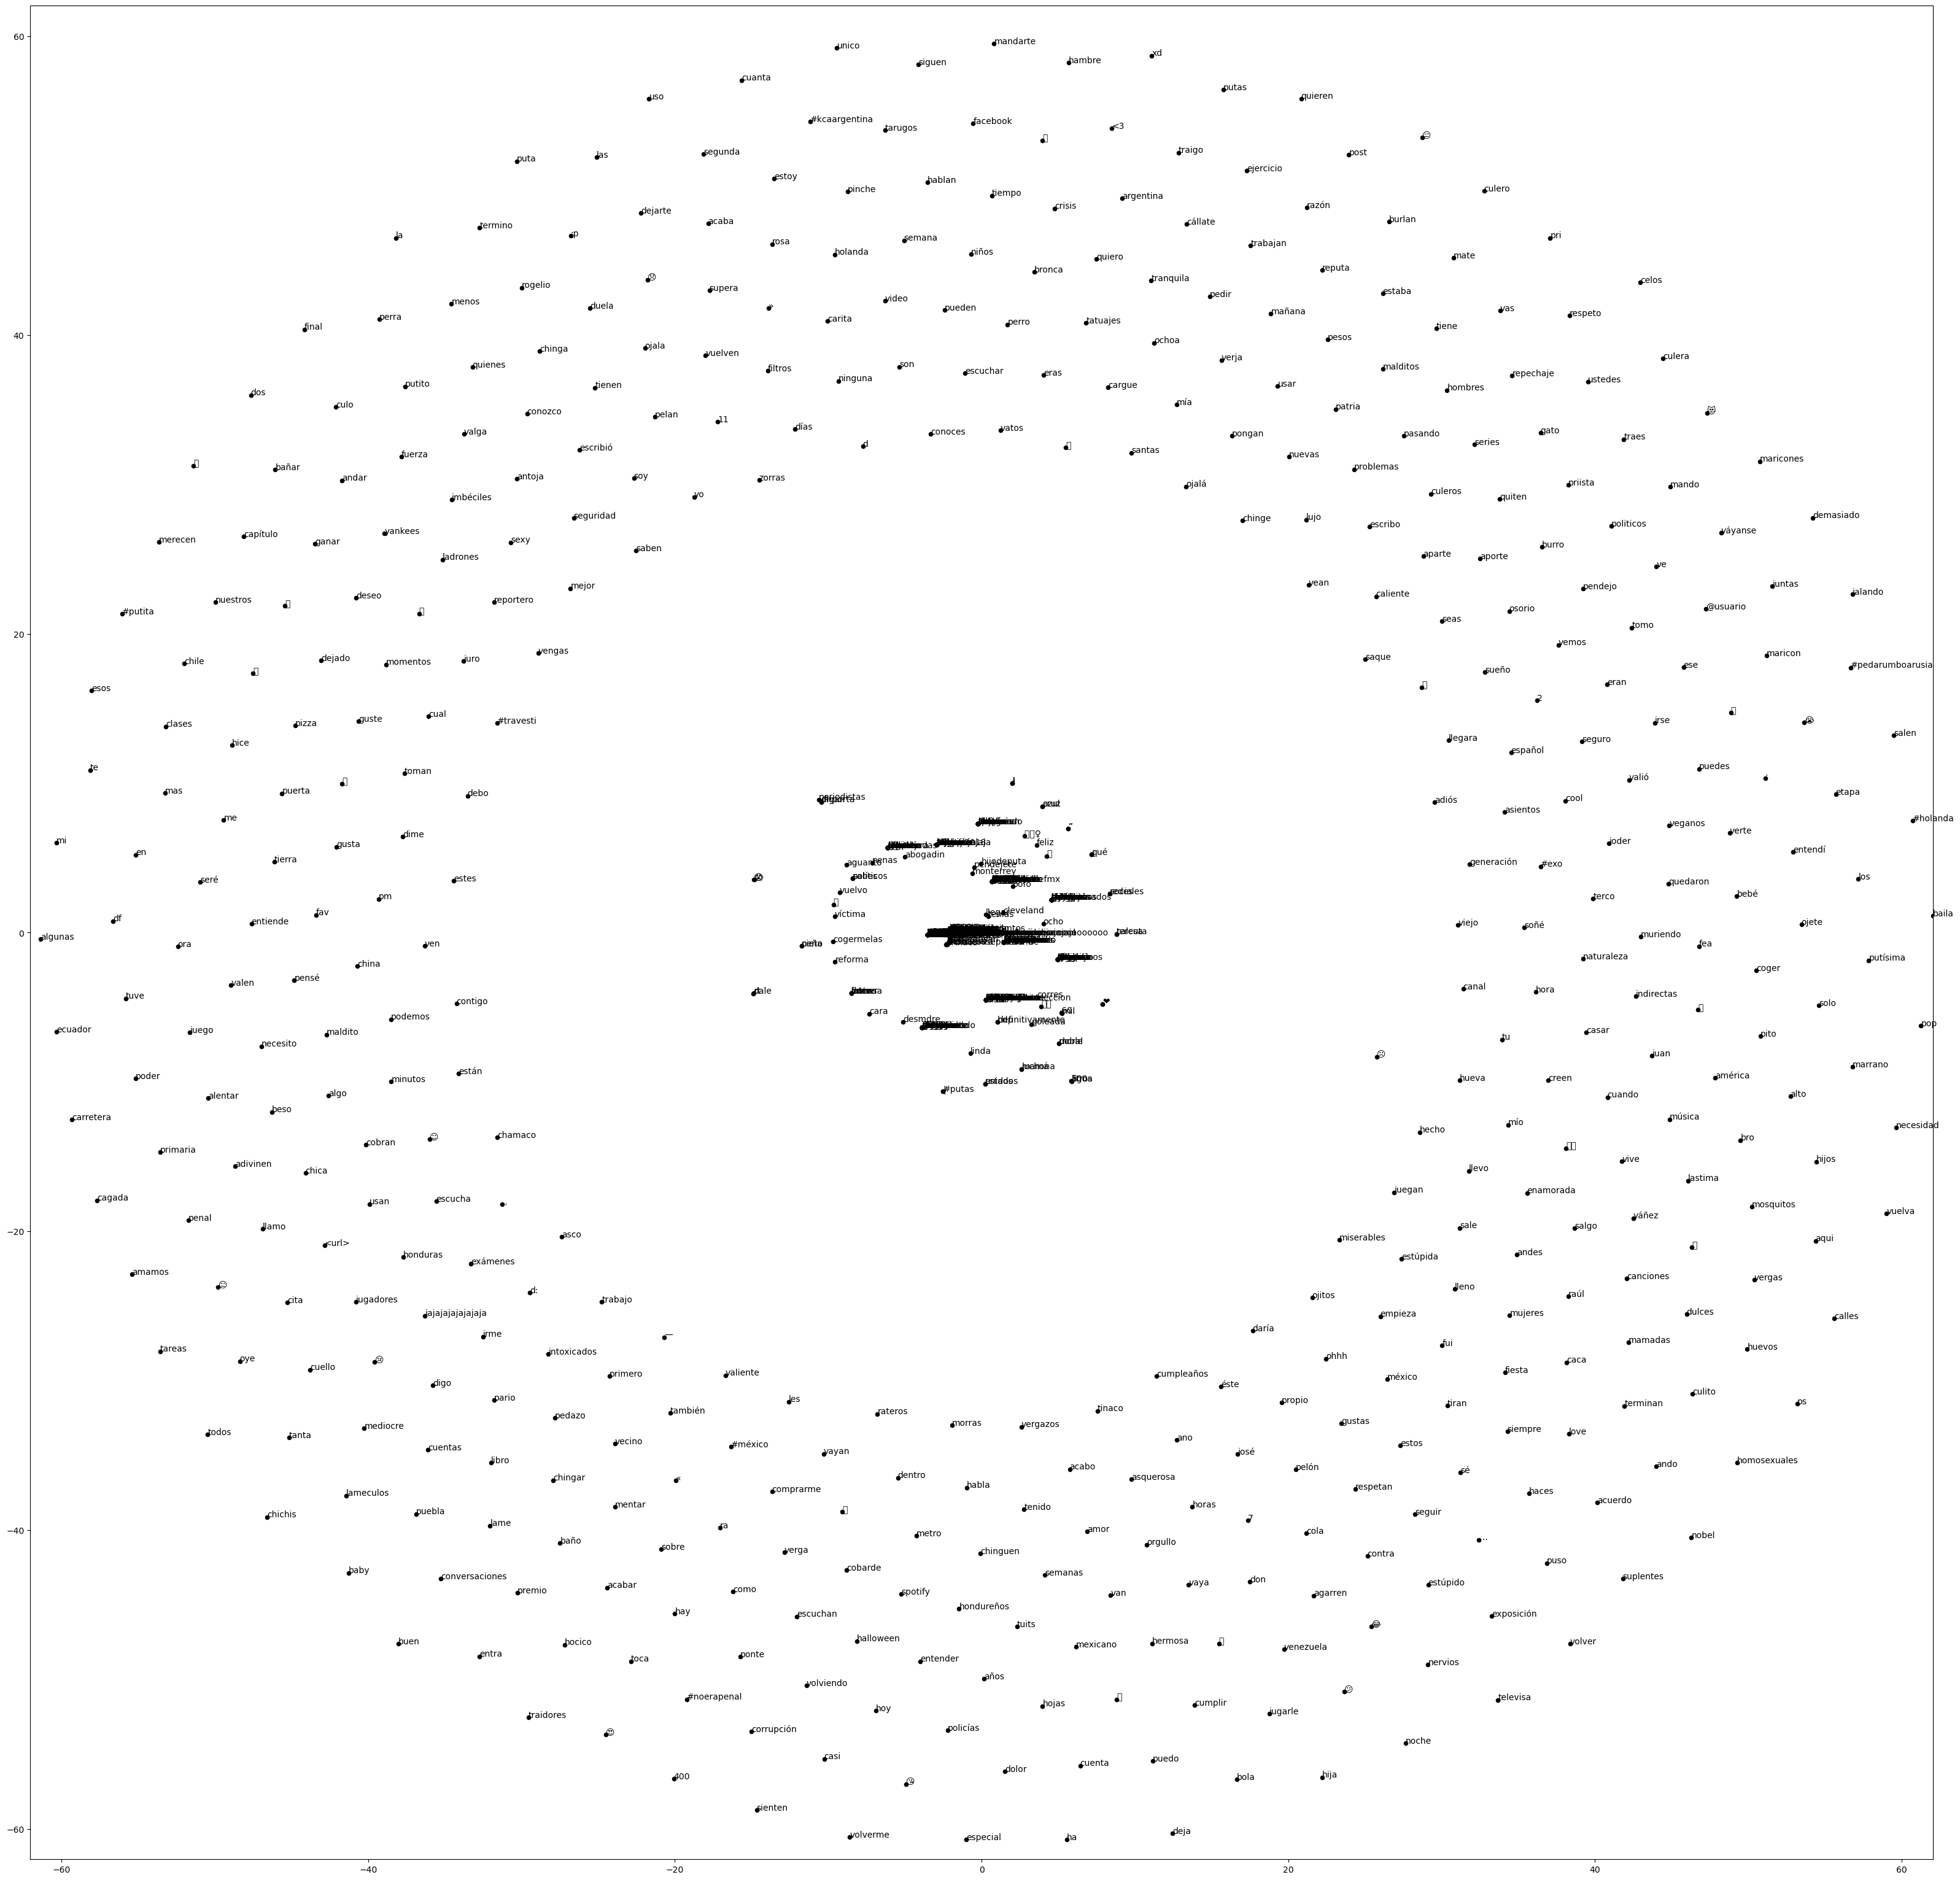

In [166]:
import matplotlib.pyplot as plt
import warnings

# shut down warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.figure(figsize=(40, 40), dpi=100); plt.xlim((-max_x, max_x)) ; plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color='black')

for (word, idx) in tcor.voc_index.items():
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    plt.annotate(word, (x,y), color='black')

# return warnings to default
#warnings.filterwarnings("default")

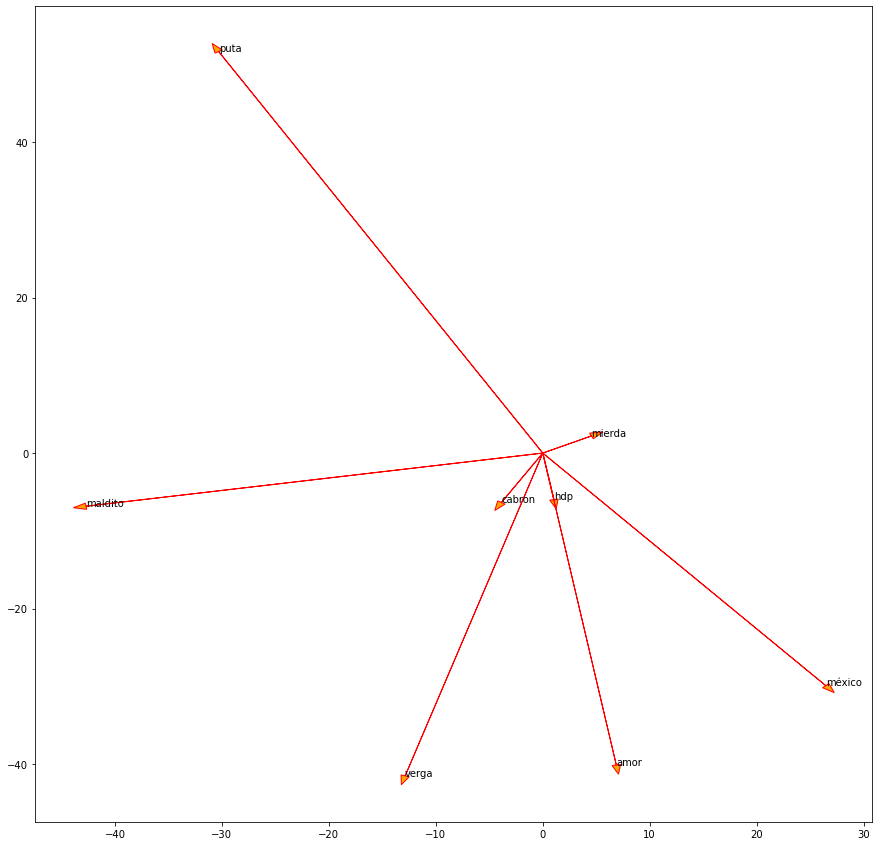

In [167]:
# get subset matrix for subset words
subset_words = ['hdp', 'mierda', 'verga', 'maldito', 'puta', 'méxico', 'cabron', 'amor']
indexes = list(map(voc_index.get, subset_words))
sub_matrix = reduced_matrix[indexes]

# base figure
fig, ax = plt.subplots(figsize=(15, 15))

# add arrows
for (x, y) in sub_matrix:
    ax.arrow(0, 0, x, y, head_width=0.8, fc='orange', ec='r')
    
# add labels
for (word, point) in zip(subset_words, sub_matrix):
    ax.annotate(word, point)
    
plt.show()

## 2000 términos y Ventana de tamaño 1

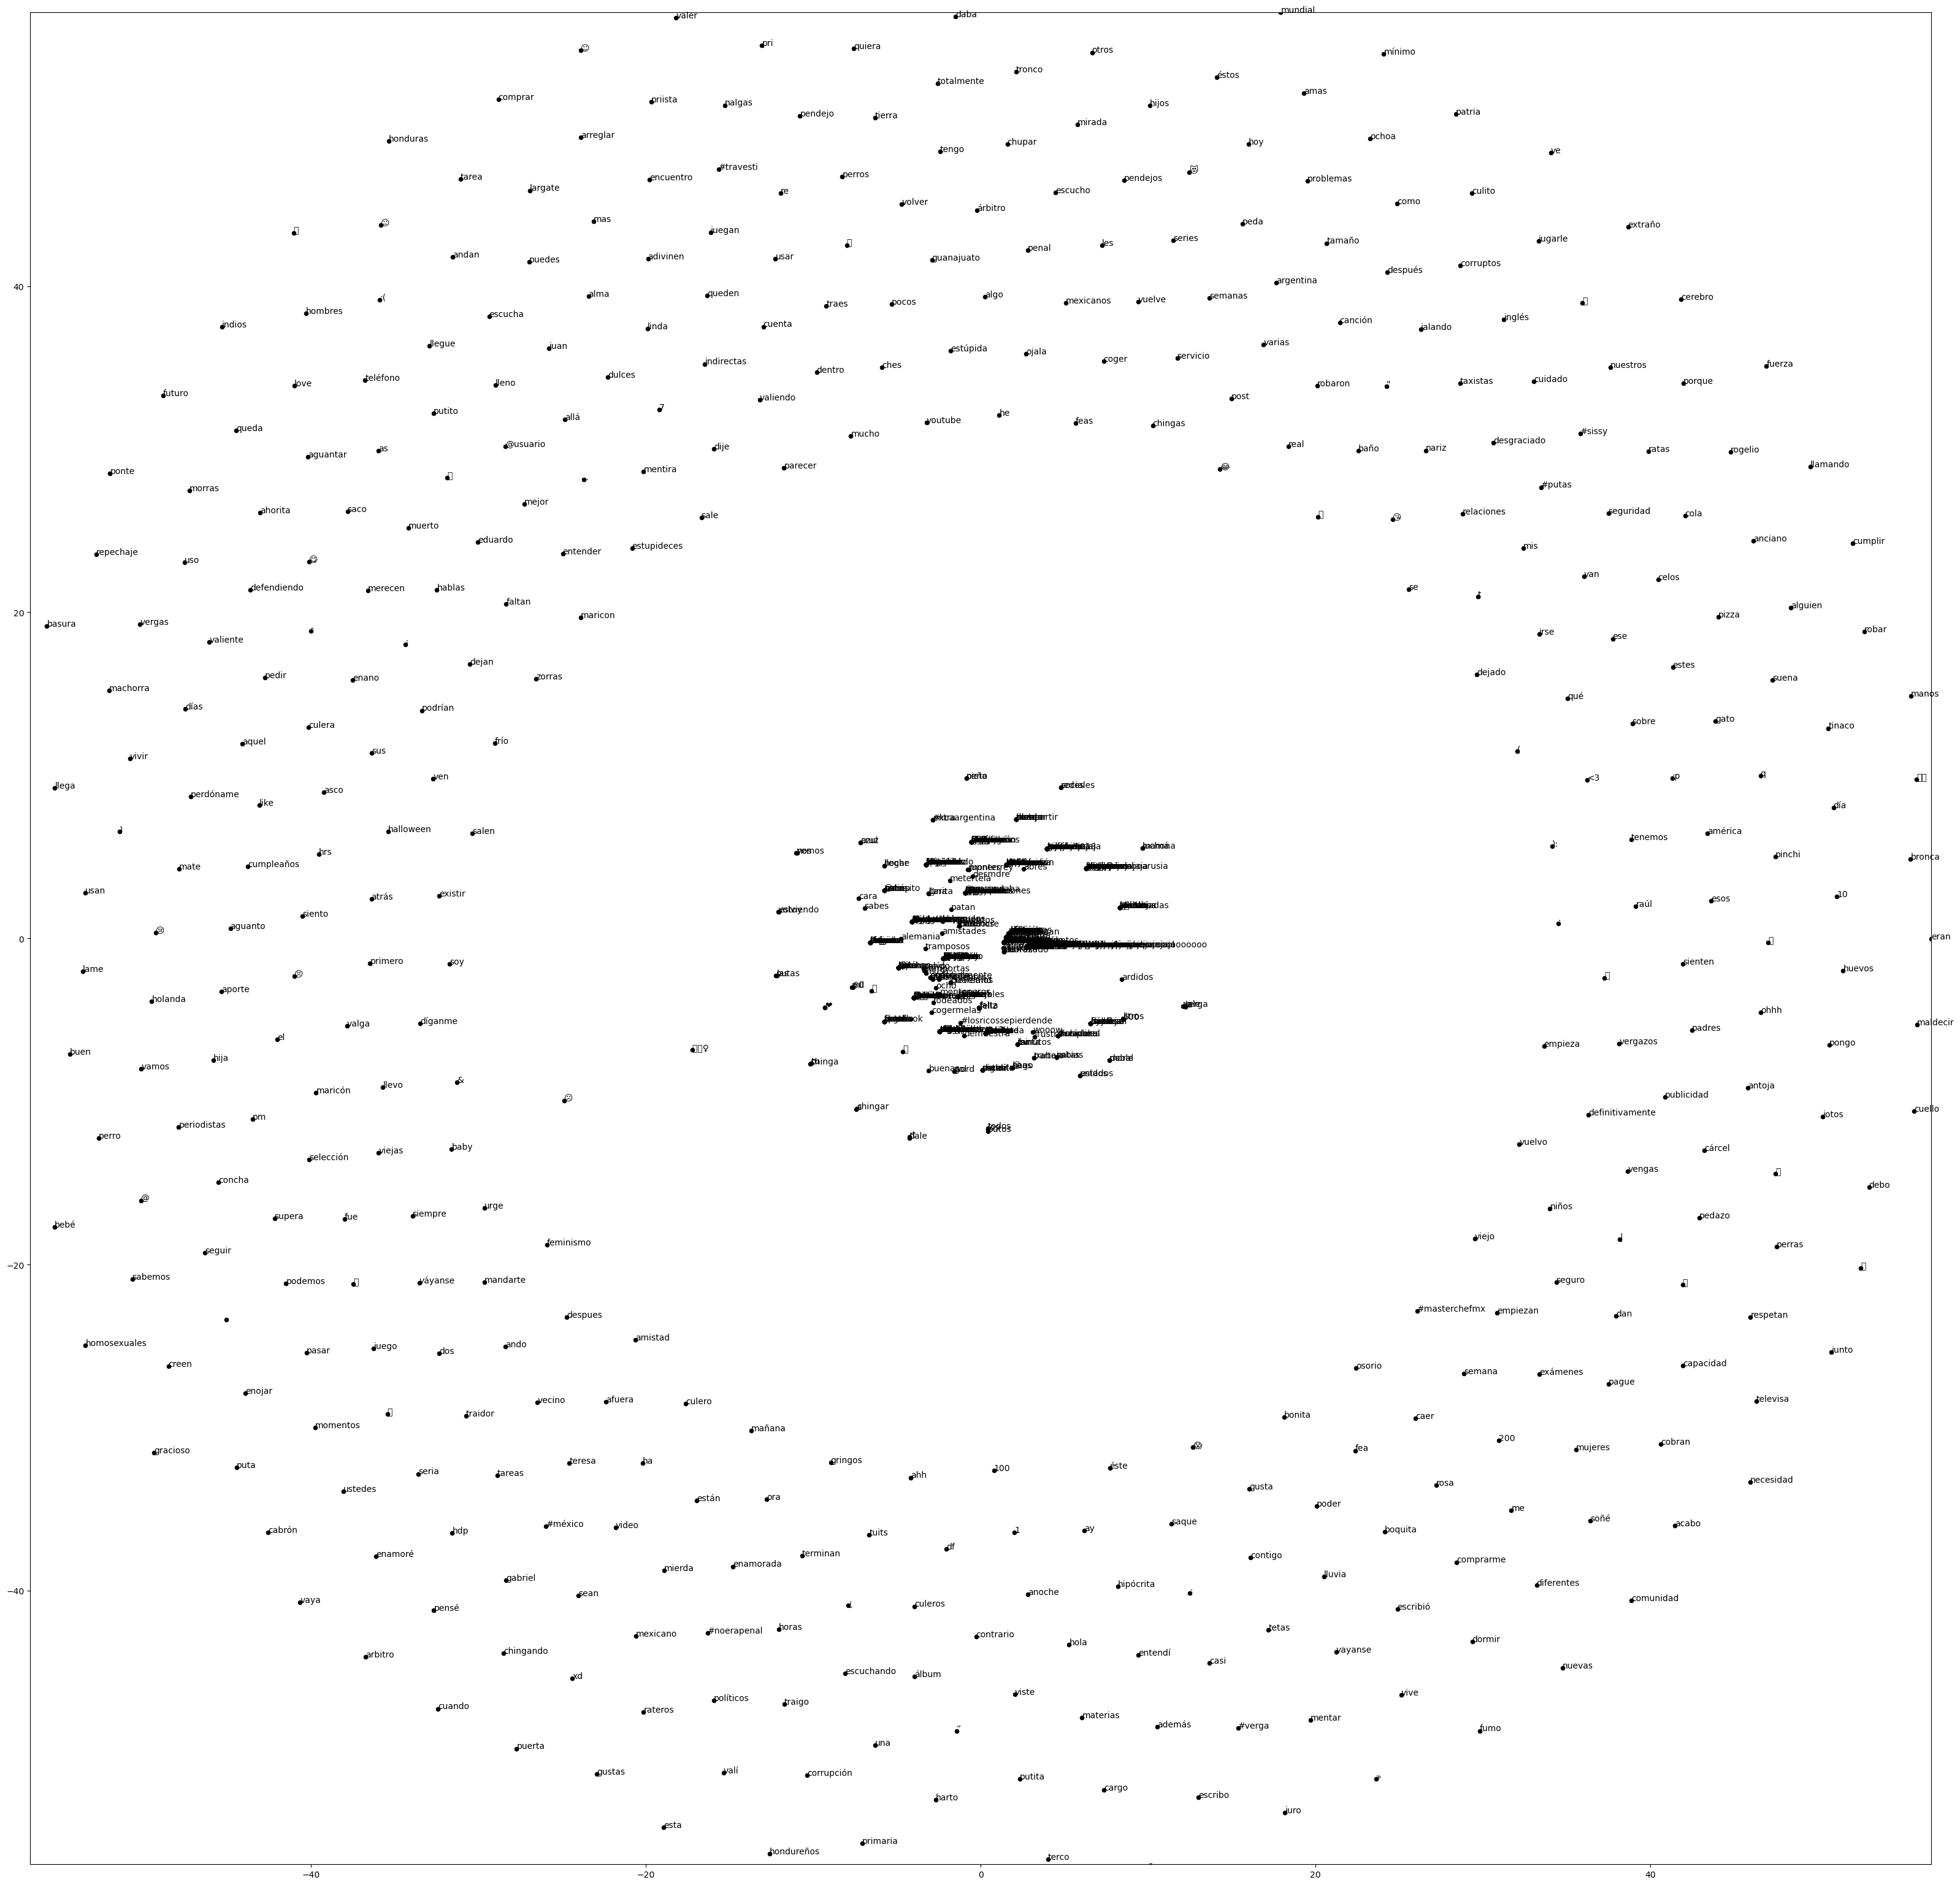

In [171]:
voc_index, _ = get_features(documents, y_train, 2000)
tcor = TCOR()
term_matrix = tcor.build_matrix(documents, 1, voc_index=voc_index)
reduced_matrix = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(term_matrix)
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[0]

plt.figure(figsize=(40, 40), dpi=100); plt.xlim((-max_x, max_x)) ; plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color='black')
for (word, idx) in tcor.voc_index.items():
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    plt.annotate(word, (x,y), color='black')

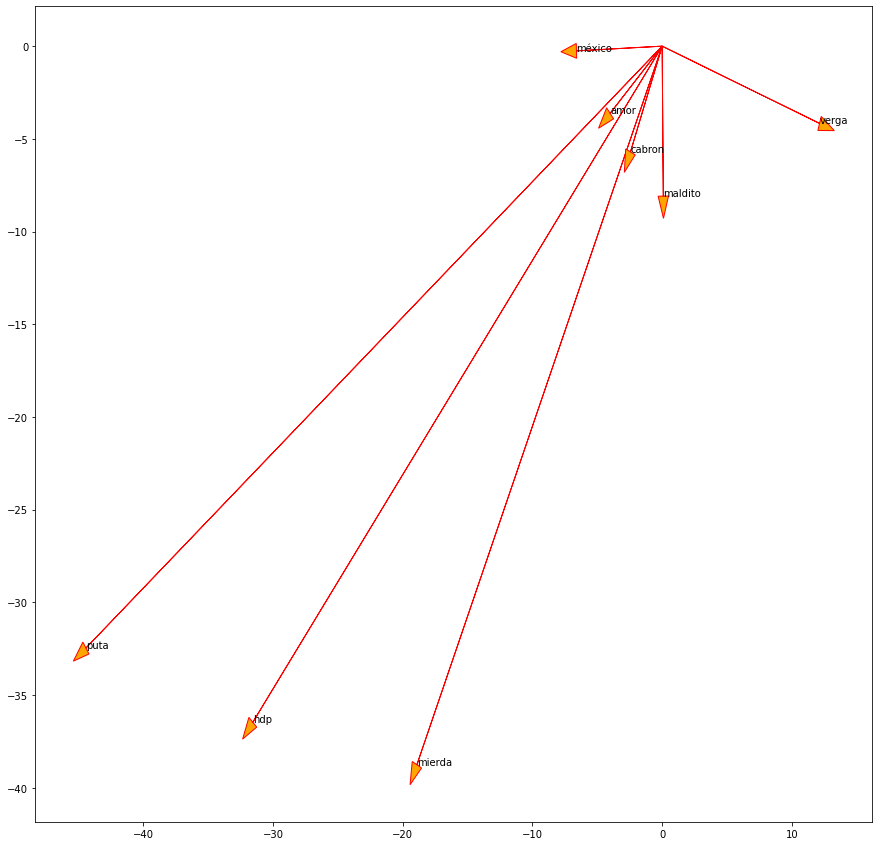

In [172]:
# get subset matrix for subset words
subset_words = ['hdp', 'mierda', 'verga', 'maldito', 'puta', 'méxico', 'cabron', 'amor']
indexes = list(map(voc_index.get, subset_words))
sub_matrix = reduced_matrix[indexes]

# base figure
fig, ax = plt.subplots(figsize=(15, 15))

# add arrows
for (x, y) in sub_matrix:
    ax.arrow(0, 0, x, y, head_width=0.8, fc='orange', ec='r')
    
# add labels
for (word, point) in zip(subset_words, sub_matrix):
    ax.annotate(word, point)
    
plt.show()

Para este ejercicio se probó con diversas configuraciones en cuanto al tamaño de la ventana de contexto y la cantidad de palabras a tomar en cuenta. En la mayoría de estas configuraciones aparecían las palabras distribuidas de la mimsma manera, es decir unas cuantás de ellas agrupadas en el centro, y las otras alrededor. A pesar de que se encuentra algunas palabras relacionadas cerca, es difícil encontrar clusters de palabras de una categoría muy específica. Esto puede deberse a el tamaño de los documentos y el ruido con el que estos documentos cuentan. 

A través de la última gŕafica de los vectores podemos ver como algunas palabras como groserías apuntan en direcciones similares, sin embargo la palabra "amor" también apunta en esta misma dirección lo cual puede justamente reflejar como estas palabras pueden tener contextos muy similares, a pesar de que denotan una emoción totalmente diferente. Por ejemplo la oración "Eres un amor" vs "Eres un hdp".

Algo a tomar en cuenta cuando se realiza proyecciones con TSNE es que las distancias entre los vectores pueden no significar nada, y que el ruido presente en el conjunto de datos puede no verse como tal en la proyección, es decir puede hacer que surjan patrones en las gŕaficas que en realidad no tienen una interpretación que refleje la naturaleza de los datos.

# Random Indexing Class

In [21]:
from nltk.probability import FreqDist
import numpy as np

class RandomIndex:
    def __init__(self):
        self.voc_index = {}
        self.T = 0
        
    def get_vocabulary(self, documents, T):
        # get vocabulary
        tokens = [token for doc in documents for token in doc]
        vocabulary = FreqDist(tokens)
        print(len(vocabulary.keys()))
        
        self.T = min(T, len(vocabulary.keys()))
        
        # get most common words
        limited_voc = vocabulary.most_common(self.T)
        
        # get index of words in matrix
        for i, word_count in enumerate(limited_voc):
            self.voc_index[word_count[0]] = i
    
    def build_matrix(self, documents, window_size, K, N1, T=5000, voc_index=None, mode='train'):
        # get most common terms - training mode
        if mode == 'train':
            if voc_index==None:
                self.get_vocabulary(documents, T) #use most common words as vocabulary
            else:
                # use vocabulary index sent as parameter. Usefull when performing a features reduction or working with n-grams
                self.voc_index = voc_index
                self.T = len(voc_index.keys())
        
        random_matrix = self.init_vector(K, N1)
        term_matrix = self.scan_documents(documents, window_size, random_matrix, True)
        return term_matrix
    
    
    def init_vector(self, K, N1):
        context_matrix = np.zeros((self.T, K))
        values = [1 for _ in range(N1)] + [-1 for _ in range(N1)]
        indexes = [np.random.choice(K, size=N1*2, replace=False) for _ in range(self.T)]
        
        for i in range(self.T):
            context_matrix[i, indexes[i]] = values
        
        return context_matrix
    
    def scan_documents(self, documents, window_size, random_v, use_center):
        term_matrix = np.zeros((self.T, random_v.shape[1]))
        
        # tf scheme
        for doc in documents:
            for c, center in enumerate(doc):
                start, end = max(0, c-window_size), min(len(doc), c + window_size + 1)
                context_words = doc[start:end] if use_center else doc[start:c] + doc[c+1:end]
                context_index = [j for j in map(self.voc_index.get, context_words) if j != None]
                i  = self.voc_index.get(center)
                if i == None:
                    continue
                    
                for j in context_index:
                    term_matrix[i] += random_v[j]
        
        return term_matrix

# 2. Random Index Matrix Y Visualizaciones

In [173]:
voc_index, _ = get_features(documents, y_train, 1000)
random_index = RandomIndex()
term_matrix = random_index.build_matrix(documents, 3, 256, 4, voc_index=voc_index)

In [174]:
import numpy as np
from sklearn.manifold import TSNE
reduced_matrix = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(term_matrix)

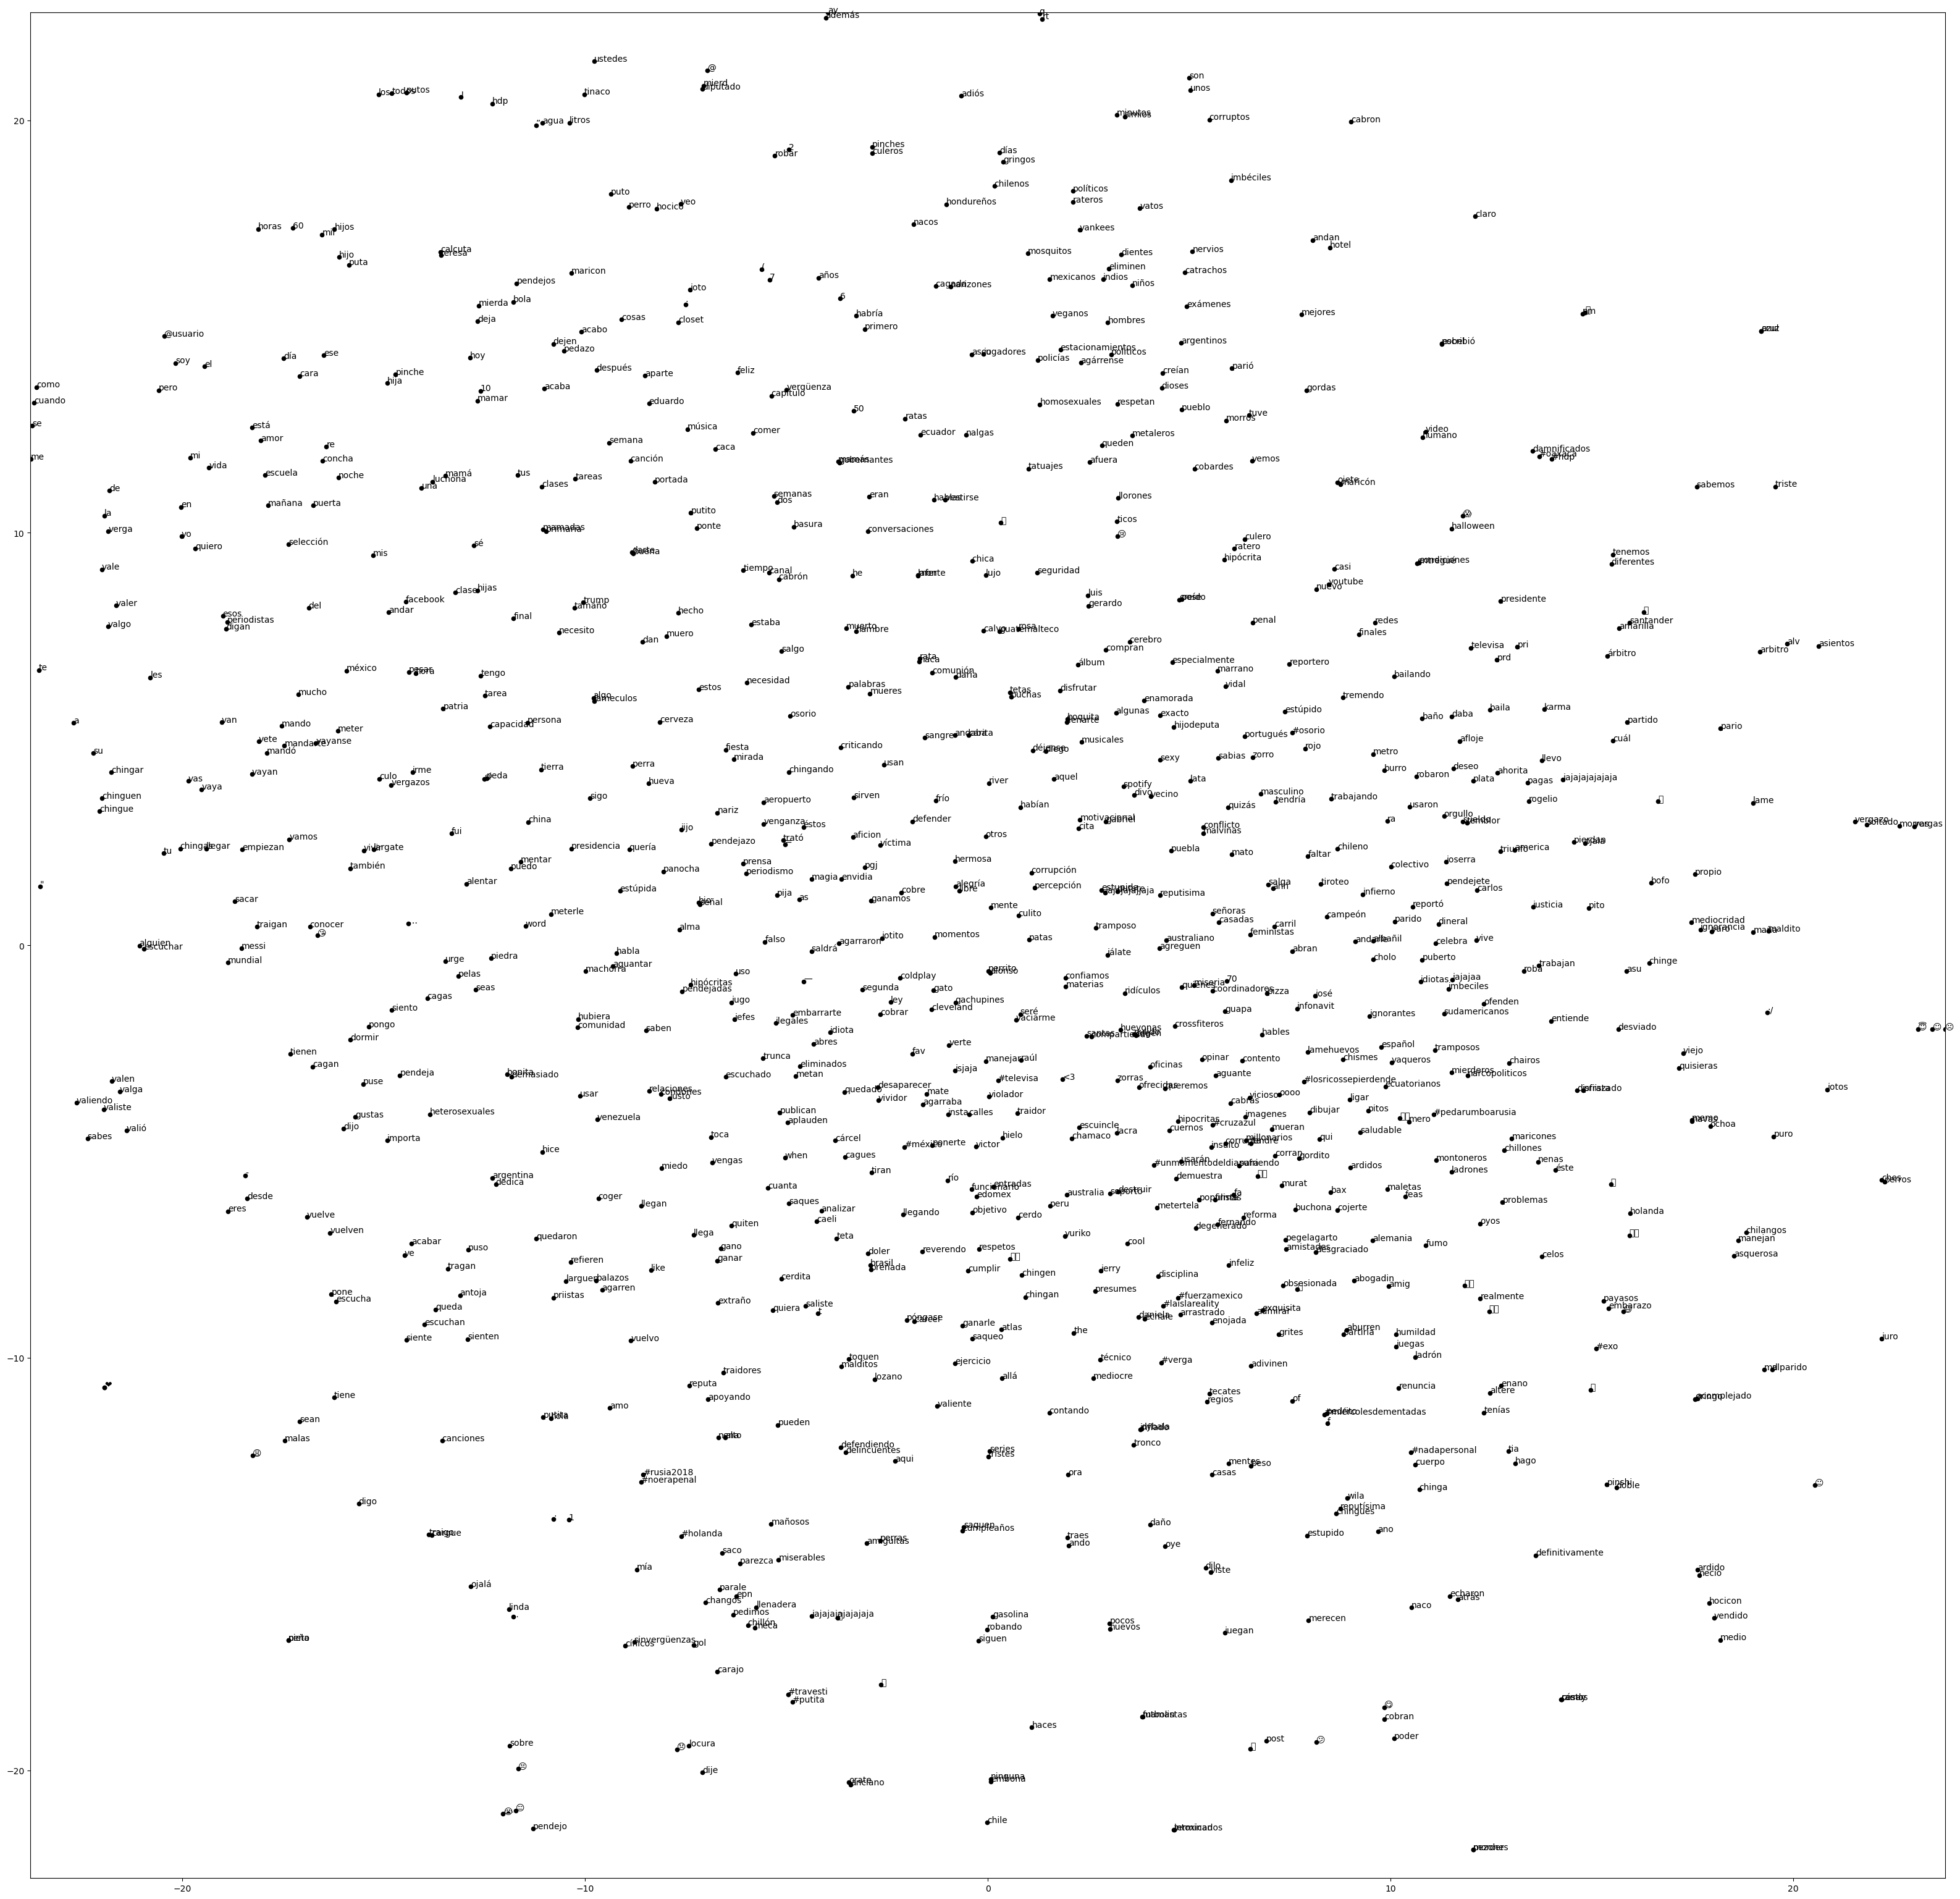

In [176]:
import warnings

# shut down warnings
warnings.filterwarnings("ignore")

max_x, max_y = np.amax(reduced_matrix, axis=0)
plt.figure(figsize=(40, 40), dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color='black')

for (word, idx) in random_index.voc_index.items():
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    plt.annotate(word, (x,y), color='black')

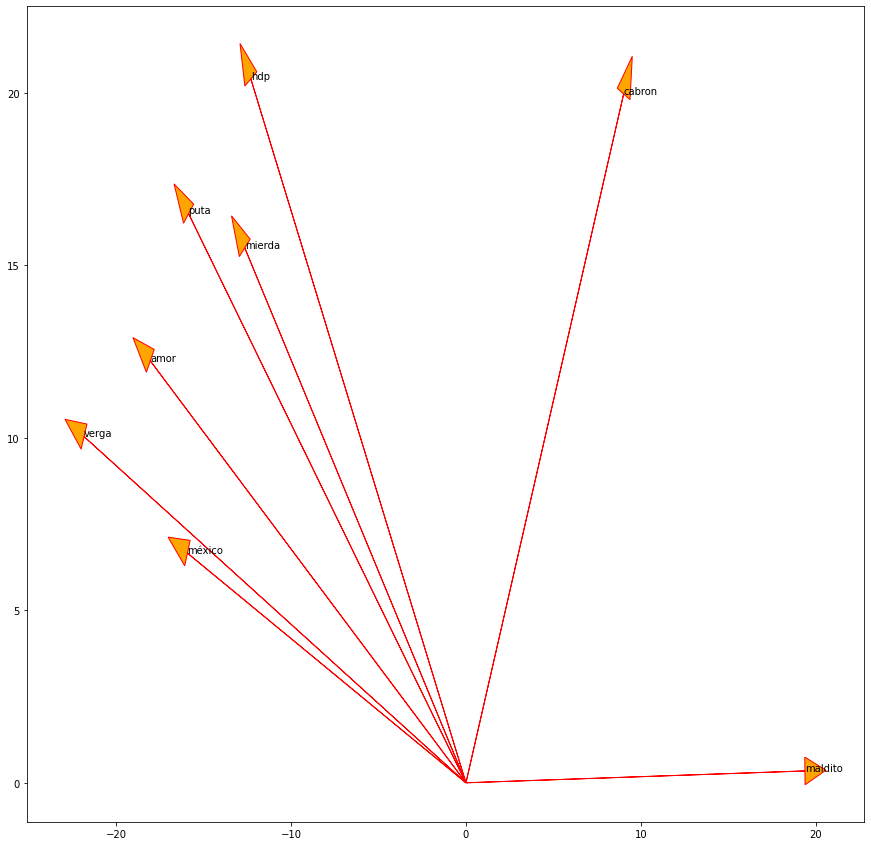

In [177]:
# get subset matrix for subset words
subset_words = ['hdp', 'mierda', 'verga', 'maldito', 'puta', 'méxico', 'cabron', 'amor']
indexes = list(map(voc_index.get, subset_words))
sub_matrix = reduced_matrix[indexes]

# base figure
fig, ax = plt.subplots(figsize=(15, 15))

# add arrows
for (x, y) in sub_matrix:
    ax.arrow(0, 0, x, y, head_width=0.8, fc='orange', ec='r')
    
# add labels
for (word, point) in zip(subset_words, sub_matrix):
    ax.annotate(word, point)
    
plt.show()

Esta representación por otro lado parece permitir visualizar mejor algunos clusters de palabras. En la proyección TSNE de esta representación si se puede observar varios clusters de palabras similares o conjugaciones de ciertas palabras. Algo a resaltar es que realizar la proyección de estas representaciones es mucho más rápido debido a que los vectores tienen una representación mucho menor de tamaño 256, y pareciera ser que logran capturar mejor ciertos clusters de palabras y algo importante es que la reducción de dimensionalidad es mucho menor. En efecto podemos corroborar que la reducción de dimensiones con esta representación es algo propio de la representación ya que nosotros escogemos el tamaño que consideremos adecuado.

También es interesante resaltar como en la gráfica de los vectores, las mismas palabras de groserías y la palabra "amor" apuntan en direcciones similares al igual que con la representación anterior.

# 3. Clasificación de Documentos

## SVM Model

In [72]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support

def get_model(max_iter=1000):
    parameters = {'C': [0.05, 0.12, 0.25, 0.5, 1, 2, 4]}
    svr = svm.LinearSVC(class_weight='balanced', max_iter=max_iter)
    grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring='f1_macro', cv=5) 
    return grid

def get_nl_model(max_iter=1000):
    parameters = {'C': [0.05, 0.12, 0.25, 0.5, 1, 2, 4]}
    svr = svm.SVC(kernel='poly', class_weight='balanced', max_iter=max_iter)
    grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring='f1_macro', cv=5) 
    return grid

def train_and_test(model, data, val_data):
    model.fit(data, y_train)
    pred = model.predict(val_data)
    p, r, f, _ = precision_recall_fscore_support(y_val, pred, average='macro', pos_label=None)
    a = accuracy_score(y_val, pred)
    print(" accuracy: ", a, "\n precision: ", p, "\n recall: ", r, "\n f_measure: ", f)

In [73]:
def build_document_matrix(documents, voc_index, term_matrix):
    N = len(documents)
    T = len(term_matrix[0])
    matrix = np.zeros((N, T))
    
    for (i, doc) in enumerate(documents):
        n_words = 0
        for word in doc:
            k = voc_index.get(word)
            if k!=None:
                matrix[i] += term_matrix[k]
                n_words += 1
        
        if n_words != 0:
            matrix[i]/= n_words
    
    return matrix

## TCOR Classification

In [79]:
voc_index, _ = get_features(documents, y_train, 1000)
tcor = TCOR()
term_matrix = tcor.build_matrix(documents, 1, alpha=0.75, voc_index=voc_index)
doc_matrix = build_document_matrix(documents, voc_index, term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, term_matrix)

In [80]:
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.7840909090909091 
 precision:  0.7646552109902895 
 recall:  0.772097811209643 
 f_measure:  0.7678350293436709


In [82]:
voc_index, _ = get_features(documents, y_train, 5000)
term_matrix = tcor.build_matrix(documents, 1, alpha=0.75, voc_index=voc_index)
doc_matrix = build_document_matrix(documents, voc_index, term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, term_matrix)
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.7857142857142857 
 precision:  0.7662337662337662 
 recall:  0.7723335978744694 
 f_measure:  0.7689343563512361


In [89]:
# 5000 words as voc, alpha =0.8
term_matrix = tcor.build_matrix(documents, 4, alpha=0.8, voc_index=voc_index)
doc_matrix = build_document_matrix(documents, voc_index, term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, term_matrix)
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.7905844155844156 
 precision:  0.7714619252873564 
 recall:  0.7781592537639603 
 f_measure:  0.7743980512788482


## Normalized TCOR Classification

In [92]:
tcor = TCOR()
voc_index, _ = get_features(documents, y_train, 5000)
term_matrix = tcor.build_matrix(documents, 1, alpha=0.75, voc_index=voc_index)
normalized_term_matrix = normalize_matrix(term_matrix)
doc_matrix = build_document_matrix(documents, voc_index, normalized_term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, normalized_term_matrix)
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.7987012987012987 
 precision:  0.78008658008658 
 recall:  0.7865038013411085 
 f_measure:  0.7829383347541914


In [93]:
# 5000 words as vocabulary
term_matrix = tcor.build_matrix(documents, 3, alpha=0.75, voc_index=voc_index)
normalized_term_matrix = normalize_matrix(term_matrix)
doc_matrix = build_document_matrix(documents, voc_index, normalized_term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, normalized_term_matrix)
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.801948051948052 
 precision:  0.7835437753179197 
 recall:  0.789022693028766 
 f_measure:  0.7860331632653061


In [107]:
# 5000 words as vocabulary
term_matrix = tcor.build_matrix(documents, 2, smooth_k=0.05, alpha=0.70, voc_index=voc_index)
normalized_term_matrix = normalize_matrix(term_matrix)
doc_matrix = build_document_matrix(documents, voc_index, normalized_term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, normalized_term_matrix)
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.801948051948052 
 precision:  0.7835497835497836 
 recall:  0.7900463522077683 
 f_measure:  0.7864393293549304


## Random Indexing Classification

In [110]:
random_index = RandomIndex()
term_matrix = random_index.build_matrix(documents, 4, 1024, 8, voc_index=voc_index)
doc_matrix = build_document_matrix(documents, voc_index, term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, term_matrix)

In [111]:
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn

 accuracy:  0.42207792207792205 
 precision:  0.6677952909126289 
 recall:  0.5495899612389726 
 f_measure:  0.3719686121771006


/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Normalized Random Indexing Classification

In [122]:
term_matrix = random_index.build_matrix(documents, 4, 1024, 8, voc_index=voc_index)
normalized_term_matrix = normalize_matrix(term_matrix)
doc_matrix = build_document_matrix(documents, voc_index, normalized_term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, normalized_term_matrix)
model = get_model(1000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.7873376623376623 
 precision:  0.7682203389830509 
 recall:  0.7766640212553052 
 f_measure:  0.7717453717453717


In [124]:
voc_index, _ = get_features(documents, y_train, 1000)
term_matrix = random_index.build_matrix(documents, 4, 1024, 8, voc_index=voc_index)
normalized_term_matrix = normalize_matrix(term_matrix)
doc_matrix = build_document_matrix(documents, voc_index, normalized_term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, normalized_term_matrix)
model = get_model(1000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.7808441558441559 
 precision:  0.7626665497896212 
 recall:  0.7757208745959996 
 f_measure:  0.767225091321325


 accuracy:  0.7597402597402597 
 precision:  0.7380960500142086 
 recall:  0.7409222134041844 
 f_measure:  0.739424703891709


## BoW TF-IDF Classification

In [123]:
# get bows, and model
bow_builder = BoWBuilder()
bow = bow_builder.build_bow(documents, T=5000, weight_scheme='tf-idf', normalize=False)
val_bow = bow_builder.build_bow(val_documents, mode='test', weight_scheme='tf-idf', normalize=False)
model = get_model(15000)
train_and_test(model, bow, val_bow)

 accuracy:  0.6948051948051948 
 precision:  0.7023890612780342 
 recall:  0.5922730984668116 
 f_measure:  0.578082191780822


## BoW TF-IDF Normalized Classification

In [112]:
# get bows, and model
bow_builder = BoWBuilder()
bow = bow_builder.build_bow(documents, T=5000, weight_scheme='tf-idf', normalize=True)
val_bow = bow_builder.build_bow(val_documents, mode='test', weight_scheme='tf-idf', normalize=True)
model = get_model(15000)
train_and_test(model, bow, val_bow)

 accuracy:  0.7256493506493507 
 precision:  0.7279454651501895 
 recall:  0.6438413673326202 
 f_measure:  0.6482200483214219


**<h2> Tabla de Resultados </h2>**

Como pudimos ver, realizamos varios experimentos con distintas configuraciones para TCOR y Random Indexing. 

En particular para random indexing no se ejecutó varios experimentos sin normalizar debido a que el clasificador SVM era demasiado lento con estos modelos. Luego de normalizar esta representación, el clasificador mejoró considerablemente tanto en las métricas como en la velocidad de convergencia. 

Algo similar ocurrió para TCOR al utilizar un valor de $\alpha=1.0$ para el esquema de pesado PPMI. El clasificador tomaba demasiado tiempo y no lograba converger en un tiempo prudencial. Pudimos entonces verificar de manera experimental que el valor de $\alpha=0.75$ propuesto en la literatura aumenta considerablemente el desempeño del clasificador. Experimentamos también con otros valores y obtuvimos un mejor desempeño para una representación TCOR normalizada, utilizando un valor de $\alpha=0.70$ con un valor de la constante de suavizado de 0.05 para el esquema de pesado PPMI.

Para el modelo de BoW no realizamos más configuraciones debido a que ya se experimentó con diversas configuraciones de este modelo en la tarea pasada. Es interesante notar como el modelo TCOR supera a la bolsa de palabras con un esquema de pesado TF-IDF, pero no logra superar a una simple bolsa de palabras con un esquema de pesado binario (dato obtenido de tarea pasada). Lo cual nuevamente resalta el poder de estos modelos tan sencillos. Claro, es importante resaltar que el conjunto de datos con el que estamos trabajando es muy ruidoso. Tal vez con un conjunto de datos diferente e incluso documentos de mayor longitud se podría obtener un mejor desempeño para estas representaciones distribucionales.

A continuación mostramos los resultados de las métricas resumidos para cada modelo en donde se tomo el mejor representante de cada uno de ellos.

**No.** | **Modelo** | **accuracy** | **precision** | **recall** | **F measure**
 -------- |----| ---- | ---- | ---- | ----
1 |`TCOR`| 0.7906  | 0.7715 | 0.7782 | 0.7744
2 | `Normalized TCOR`  | **0.8019** | **0.7835** | **0.7900** | **0.7864**
3 | `Random Indexing` | 0.4221 | 0.6678 | 0.5496 | 0.3720 
4 | `Normalized Random Indexing` | 0.7873 | 0.7682 | 0.7767 | 0.7717
5 | `BoW TF-IDF` | 0.6948 | 0.7024 | 0.5923 | 0.5781 
5 | `BoW Normalized TF-IDF` | 0.7256 | 0.7279 | 0.6438 | 0.6482


# Distancia Coseno

In [62]:
def cos_distance(data):
    N = len(data)
    distances = np.zeros((N, N))
    magnitudes = np.linalg.norm(data, axis=1)
    
    for i in range(N):
        for j in range(i+1):
            distances[i, j] = np.dot(data[i], data[j])/(magnitudes[i] * magnitudes[j])
            if i != j:
                distances[j, i] = distances[i, j]
    
    return distances

In [63]:
def get_most_similar(dist_matrix, n):
    N = len(dist_matrix)
    
    # get indexes of elements to be compared. dist_matrix should be symmetric, so we dont need to consider each pair of distances twice
    indexes = [(i,j) for i in range(N) for j in range(i+1) if i!=j]

    # get x and y indexes
    x_indexes = tuple([ind[0] for ind in indexes])
    y_indexes = tuple([ind[1] for ind in indexes])
    
    # get values of matrix
    row_max = dist_matrix[x_indexes, y_indexes]
    
    # desc sort elements retrieved and get their positions
    max_elements = np.flip(np.argsort(row_max))[:n]
    
    # return indexes in positions retrieved in previous step
    return [indexes[max_index] for max_index in max_elements]

# 4. 10 Términos más Similares

In [137]:
voc_index, _ = get_features(all_docs, y_all, 5000)
term_matrix = TCOR().build_matrix(all_docs, 3, alpha=0.75, voc_index=voc_index)
tcor_distances = cos_distance(term_matrix)
dist_matrix = np.nan_to_num(tcor_distances)

In [138]:
indexes = get_most_similar(dist_matrix, 10)
for (i, j) in indexes:
    l_voc = list(voc_index)
    print("{0:20}, {1:20}, score: {2}".format(l_voc[i], l_voc[j], dist_matrix[i, j]))

😆                   , 🖕                   , score: 0.9981788091025223
calcuta             , teresa              , score: 0.9961153036743872
🇽                   , 🇲                   , score: 0.9951655653252013
️                   , ❤                   , score: 0.92847453688514
“                   , ”                   , score: 0.8995608046805493
💦                   , 🍆                   , score: 0.8958131106823534
nieto               , peña                , score: 0.8498859030196444
🔁                   , ️                   , score: 0.8432833990658574
v                   , :                   , score: 0.7577483932877772
|                   , #putas              , score: 0.7403016177502474


In [145]:
# now with a voc o 1000 words and a window of size 2
voc_index, _ = get_features(all_docs, y_all, 1000)
term_matrix = TCOR().build_matrix(all_docs, 2, alpha=0.75, voc_index=voc_index)
tcor_distances = cos_distance(term_matrix)
dist_matrix = np.nan_to_num(tcor_distances)

# get pair of words
indexes = get_most_similar(dist_matrix, 10)
for (i, j) in indexes:
    l_voc = list(voc_index)
    print("{0:20}, {1:20}, score: {2}".format(l_voc[i], l_voc[j], dist_matrix[i, j]))

mon                 , laferte             , score: 0.9999999999999998
césar               , ramos               , score: 0.9999994294482438
calcuta             , teresa              , score: 0.9989799331261183
azul                , cruz                , score: 0.9921882879708812
nieto               , peña                , score: 0.9844321343200974
amig                , @                   , score: 0.9723762365064549
estados             , unidos              , score: 0.9650982341564003
|                   , #putas              , score: 0.9488016275060472
luis                , gerardo             , score: 0.9191308821850341
méndez              , gerardo             , score: 0.900817137498724


Podemos observar que los pares de términos más parecidos son en muchos escenarios palabras que suelen ir juntas como "peña nieto" o "teresa calcula", incluso el emoji ":v". Al trabajar con tweets que son documentos muy pequeños, puede ser que estas palabras que suelen ir juntas terminen siendo las más parecidas ya que en los contextos que suelen ser utilizadas probablemente una gran cantidad de veces van acompañadas. Al trabajar con ventanas de tamaño 3 esta información se puede capturar.  

Notemos como al cambiar el tamaño de la ventana y la cantidad de términos a 1000 a través de un corte con la métrica chi cuadrado obtenemos que en su mayoría tenemos nombres de personas que suelen ir juntos. 

# 5. 10 Documentos más Similares

In [139]:
voc_index, _ = get_features(all_docs, y_all, n=5000)
bow_builder = BoWBuilder()
bow = bow_builder.build_bow(all_docs, voc_index=voc_index, weight_scheme='tf-idf')
distances = cos_distance(bow)
distances = np.nan_to_num(distances)
indexes = get_most_similar(distances, 10)

In [141]:
docs = all_docs
for n_pair, (i, j) in enumerate(indexes):
    i_label = 'agresivo' if y_all[i]==1 else 'no agresivo'
    j_label = 'agresivo' if y_all[j]==1 else 'no agresivo'
    print('\n\033[1mPAIR No.\033[0m ', n_pair + 1)
    print('Document: ', i)
    for word in docs[i]:
        print(word, end=' ')
    
    print('\nLabel:', i_label)
    print('\nDocument: ', j)
    for word in docs[j]:
        print(word, end=' ')
        
    print('\nLabel:', j_label)    
    print('\n\033[1mscore:\033[0m ', distances[i, j], '\n')


PAIR No.  1
Document:  3373
madre preocupada por los tatuajes de su hijo toma medidas desesperadas 
Label: no agresivo

Document:  1314
#deforma #deforma madre preocupada por los tatuajes de su hijo toma medidas desesperadas 
Label: no agresivo

score:  1.0 


PAIR No.  2
Document:  4152
una flaquita tetona recibe su dotación mientras chupa otra verga ! ¡ mira su cara de placer ! rt para más vídeos 
Label: no agresivo

Document:  2720
una flaquita tetona recibe su dotación mientras chupa otra verga ! ¡ mira su cara de placer ! rt para más vídeos 
Label: no agresivo

score:  1.0 


PAIR No.  3
Document:  5282
buenos días que chingue su madre terco . 
Label: agresivo

Document:  4760
🖤 si que chingue su madre terco de buenos días . 
Label: no agresivo

score:  0.9978435933411804 


PAIR No.  4
Document:  5227
quiero un pasivo que se ensarte mi verga así 🔥 🔥 como @usuario cabalga la verga de @usuario 
Label: no agresivo

Document:  3693
quiero un pasivo que se ensarte mi verga así 🔥 🔥 co

Como pudimos ver la bolsa de palabras logra capturar muy bien documentos que son muy parecidos, casi idénticos. Esto no es de extrañar ya que evalua los vectores en función de las palabras que tiene. Podemos observar que el primer par de documentos tiene un score de 1 a pesar de que el primero tiene dos palabras que no aparecen en el 2ndo documento. Esto probablemente se debe a que el esquema la selección de características a través de la métrica chi cuadrado elimina estas palabras debido a que no son de mayor relevancia.  

# 6. Nube de Palabras

In [142]:
top_50, chi = get_features(all_docs, y_all, 50)
frequencies = {}
for (word, weight) in zip(top_50.keys(), chi):
    frequencies[word] = weight

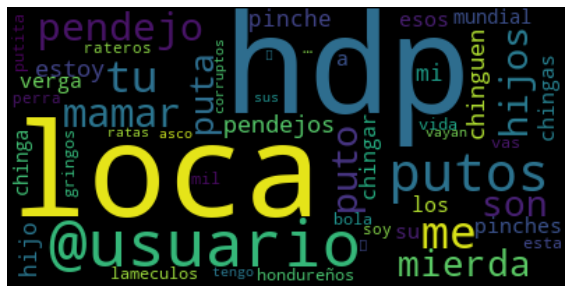

In [143]:
import os
from os import path
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate_from_frequencies(frequencies)

# Display the generated image:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Para este ejercicio seleccionamos las 50 palabras con un mayor score de la métrica chi cuadrado. Luego utilizamos este valor para que las palabras fueran graficadas en función de este valor. Podemos ver que una gran cantidad de palabras seleccionadas son palabras que pueden usarse en contextos agresivos, es decir la presencia o ausencia de estas palabras puede ayudar a determinar si el documento es agresivo o no. De hecho, es interesante resaltar que las palabras más grandes son todas  palabras agresivas a excepción de la palabra @usuario.